# Univariate analysis to look at SNR issue for ROIs

ROI: OFC, amygdala

video onset time series.
fit_transform()


*Yiyu Wang 2023/08*

In [1]:
import os

import glob
import nibabel as nib
import numpy as np
import pandas as pd
import copy

from nilearn import datasets
from nilearn.image import new_img_like, load_img, get_data, concat_imgs, mean_img, math_img, index_img,threshold_img,smooth_img, resample_to_img
from nilearn import plotting
from nilearn.plotting import plot_glass_brain
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_design_matrix
from nilearn.masking import apply_mask
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
from nilearn.glm.first_level import FirstLevelModel

from nilearn.glm.second_level import SecondLevelModel
from scipy.stats import norm


import gzip

import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

/Users/yiyuwang/anaconda3/lib/python3.7/site-packages/nilearn/__init__.py:67: FutureWarning: Python 3.7 support is deprecated and will be removed in release 0.12 of Nilearn. Consider switching to Python 3.9 or 3.10.
  _python_deprecation_warnings()
/Users/yiyuwang/anaconda3/lib/python3.7/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)
/Users/yiyuwang/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# project directory
data_dir = 'transformed_data/'


subjects_list = ['04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','23','25','26','28','29']
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )

mask_path = 'masks/FSL_binary_MNI152_T1_3mm_brain.nii.gz'
mask = nib.load(mask_path)

subjects in this analysis:
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '23', '25', '26', '28', '29']
**** n = 21 *****


(60, 72, 60)


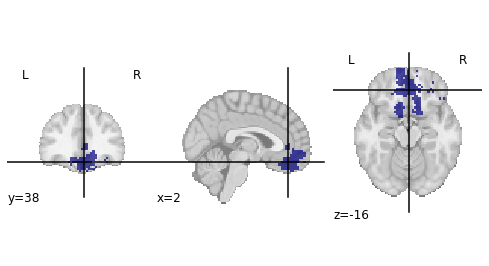

In [4]:
# medial OFC:
# mask downloaded from neurosynth
ofc_mask = nib.load('masks/medial orbitofrontal_association-test_z_FDR_0.01.nii.gz')

ofc_mask_resampled = resample_to_img(ofc_mask,mask_path)
ofc_mask_resampled = math_img('img>2.6', img=ofc_mask_resampled)
print(ofc_mask_resampled.shape)

plotting.plot_roi(ofc_mask_resampled)

In [ ]:
# examine whether they are present in any situation prediction maps:

In [25]:
# apply mask to each individual data, and plot:
ofc_masker = NiftiMasker(mask_img=ofc_mask_resampled, standardize=False)


har_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm')
har_sub_labels = har_sub['labels']
l_amy_label_index = np.where(np.array(har_sub_labels) == 'Left Amygdala')[0][0]
r_amy_label_index = np.where(np.array(har_sub_labels) == 'Right Amygdala')[0][0]
subc_masker = NiftiLabelsMasker(labels_img=har_sub.maps, standardize=False)


# for s in subjects_list:

sub_amy_list, sub_ofc_list = [], []
std_amy_list, std_ofc_list = [], []
for s in subjects_list:
    sub_dir = data_dir + f'{s}/'
    
    run_list = glob.glob(sub_dir + '*.nii.gz')
    sub_data = mean_img(load_img(run_list))
    sub_ofc = ofc_masker.fit_transform(sub_data)
    sub_amy = subc_masker.fit_transform(sub_data)[:,[l_amy_label_index, r_amy_label_index]].mean()
    
    mean_amy = sub_amy.mean()
  
    
    mean_ofc = sub_ofc.mean()
   
    
    sub_ofc_list.append(mean_ofc)
    sub_amy_list.append(mean_amy)
    

    
    
df = pd.DataFrame({'sub': subjects_list, 'amygdala_mean':sub_amy_list, 'OFC_mean': sub_ofc_list})    
    
    

df.head()



,sub,amygdala_mean,OFC_mean
0,04,377.824097,320.021545
1,05,405.195312,377.866150
2,06,405.658691,410.915039
3,07,372.520142,340.473999
4,08,294.034210,321.242096


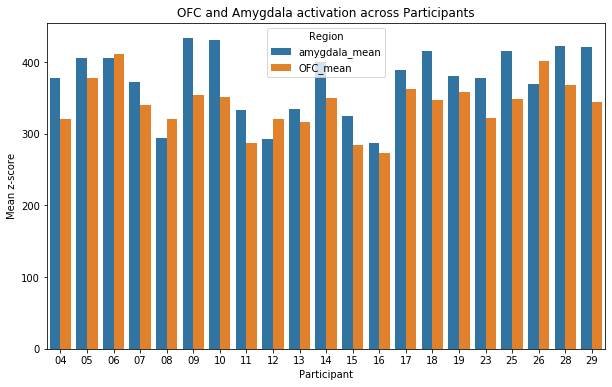

In [32]:
# Melting the DataFrame to long format
df_melted = pd.melt(df, id_vars='sub', value_vars=['amygdala_mean', 'OFC_mean'],
                    var_name='region', value_name='mean')


# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='sub', y='mean', hue='region', ci='sd', capsize=.1)
plt.title('OFC and Amygdala activation across Participants')
plt.ylabel('Mean z-score')
plt.xlabel('Participant')
plt.legend(title='Region')
plt.show()

In [ ]:
# apply mask to each individual data, and plot:
ofc_masker = NiftiMasker(mask_img=ofc_mask_resampled, standardize=False)


har_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm', data_dir = '/work/abslab/Yiyu/nilearn_atlas/')
har_sub_labels = har_sub['labels']
l_amy_label_index = np.where(np.array(har_sub_labels) == 'Left Amygdala')[0][0]
r_amy_label_index = np.where(np.array(har_sub_labels) == 'Right Amygdala')[0][0]
subc_masker = NiftiLabelsMasker(labels_img=har_sub.maps, standardize=False)


# for s in subjects_list:

sub_amy_list, sub_ofc_list = [], []
std_amy_list, std_ofc_list = [], []
for s in subjects_list:
    sub_dir = data_dir + f'{s}/'
    
    run_list = glob.glob(sub_dir + '*.nii.gz')
    sub_data = load_img(run_list)
    sub_ofc = ofc_masker.fit_transform(sub_data).mean(axis=1)
    sub_amy = subc_masker.fit_transform(sub_data)[:,[l_amy_label_index, r_amy_label_index]].mean(axis=1)
    
    mean_amy = sub_amy.mean()
    std_amy = sub_amy.std()
    
    mean_ofc = sub_ofc.mean()
    std_ofc = sub_ofc.std()
    
    sub_ofc_list.append(mean_ofc)
    sub_amy_list.append(mean_amy)
    
    std_amy_list.append(std_amy)
    std_ofc_list.append(std_ofc)
    
    
    
df = pd.DataFrame({'sub': subjects_list, 'amygdala_mean':sub_amy_list, 'OFC_mean': sub_ofc_list, 'amygdala_std': std_amy_list, 'OFC_std': std_ofc_list})    
    
    

df.head()



In [30]:
# Melting the DataFrame to long format
df_melted = pd.melt(df, id_vars='sub', value_vars=['amygdala_mean', 'OFC_mean'],
                    var_name='region', value_name='mean')

# Extracting std values and adding to melted DataFrame
df_err_melted = pd.melt(df, id_vars='sub', value_vars=['amygdala_std', 'OFC_std'],
                        var_name='region', value_name='std')
df_melted['std'] = df_err_melted['std']

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='sub', y='mean', hue='region', ci='sd', capsize=.1)
plt.title('OFC and Amygdala activation across Participants')
plt.ylabel('Mean z-score')
plt.xlabel('Participant')
plt.legend(title='Region')
plt.show()

KeyError: "The following 'value_vars' are not present in the DataFrame: ['OFC_std', 'amygdala_std']"

In [ ]:
# apply mask to each individual data, and plot:
ofc_masker = NiftiMasker(mask_img=ofc_mask_resampled)
amy_masker = NiftiMasker(mask_img=ofc_mask_resampled)
# for s in subjects_list:

sub_amy_list, sub_ofc_list = [], []
std_amy_list, std_ofc_list = [], []
for s in subjects_list:
    sub_dir = data_dir + f'{s}/'
    
    run_list = glob.glob(sub_dir + '*.nii.gz')
    sub_data = load_img(run_list)
    sub_ofc = ofc_masker.fit_transform(sub_data)
    sub_amy = subc_masker.fit_transform(sub_data)[0,[l_amy_label_index, r_amy_label_index]]
    
    mean_amy = sub_amy.mean()
    std_amy = sub_amy.std()
    
    mean_ofc = sub_ofc.mean()
    std_ofc = sub_ofc.std()
    
    sub_ofc_list.append(mean_ofc)
    sub_amy_list.append(mean_amy)
    
    std_amy_list.append(std_amy)
    std_ofc_list.append(std_ofc)
    
    
    
df = pd.DataFrame({'sub': subjects_list, 'amygdala':sub_amy_list, 'OFC': sub_ofc_list})    
    
    

df.head()


In [10]:
# local directory set up
base_dir = '/work/abslab/Yiyu/AffVids/'
data_dir = base_dir + 'transformed_data/'

logfiles_dir = base_dir + 'logfiles/'
confounds_dir = base_dir + 'confounds/'
mask_dir = base_dir + 'masks/'
figures_dir = base_dir + 'figures/'

visual_reg_dir = base_dir + 'fmri_regressors/add_visual_reg/'

#mask for 1st level:
mask_path = mask_dir +'FSL_binary_MNI152_T1_3mm_brain.nii.gz'
mask = nib.load(mask_path)

logfile_headers =np.array(['video_name', 'run_number', 'video_category', 'experimenter_high_low', 'same_category_prior', 
                  'cue_onset','cue_offset', 'expected_fear', 'expected_fear_RT',
                 'video_onset', 'video_offset', 'fear_rating', 'arousal_rating', 'valence_rating'
                  'fear_rating_RT', 'arousal_rating_RT', 'valence_rating_RT'])

subjects_list = ['04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','23','25','26','28','29']
sample_n = len(subjects_list)
print("subjects in this analysis:")
print(subjects_list)
print(f"**** n = {sample_n} *****" )
vmax = 12

TR = .001
N_TR = 552
TR_Length = 1
TR_IN_MS = int(TR_Length/TR)

fwhm = 6

mask = nib.load(mask_path)
# resample a gray matter mask
from nilearn.datasets import load_mni152_gm_mask
gm_mask = load_mni152_gm_mask(resolution=3, threshold=0.2, n_iter=2)
gm_mask_img = math_img('img > 0.2', img=gm_mask)
plotting.view_img(mask, threshold=None)


confounds_of_interest = ['CSF',
                        'WhiteMatter',
                        'X', 
                        'Y', 
                        'Z',
                        'RotX',
                        'RotY',
                        'RotZ','FramewiseDisplacement']

subjects in this analysis:
['04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '23', '25', '26', '28', '29']
**** n = 21 *****


/home/wang.yiyu/.local/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


In [11]:
# helper functions for univariate 1st level

def AddSteadyStateOutliers(columns_of_interest, all_columns):
    new_columns = copy.deepcopy(columns_of_interest)
    for column in all_columns:
        if 'Outlier' in column:
            new_columns.append(column)
            
    return new_columns


def AddVisualProperty(cov, s, run):
    new_cov = copy.deepcopy(cov)
    visual_reg = pd.read_csv(visual_reg_dir + f'subject_{s}_run_{run}.csv')
    new_cov = pd.concat([cov, visual_reg], axis =1)
    return new_cov

def CreateConfoundMatrix(confound_file_path, 
                         confounds_of_interest, s, run, add_vis=False):
    
    
    confounds = pd.read_csv(confound_file_path, sep='\t')
    
    confounds_of_interest = AddSteadyStateOutliers(confounds_of_interest, confounds.columns)
    
    cov = confounds[confounds_of_interest]
    if add_vis:
        cov = AddVisualProperty(cov, s, run)
    cov.values[np.isnan(cov.values)]=0
    
    return cov


In [12]:
# epxeriment-related helper functions:

logfile_headers =np.array(['video_name', 'run_number', 'video_category', 'experimenter_high_low', 'same_category_prior', 
                  'cue_onset','cue_offset', 'expected_fear', 'expected_fear_RT',
                 'video_onset', 'video_offset', 'fear_rating', 'arousal_rating', 'valence_rating',
                  'fear_rating_RT', 'arousal_rating_RT', 'valence_rating_RT'])


def check_high_low(video_num):
    if video_num in [1,2,3,4,5,6,13,14,15,16,17,18,25,26,27,28,29,30]:
        vid_type = 'high'
    elif video_num in [7,8,9,10,11,12,19,20,21,22,23,24,31,32,33,34,35,36]:
        vid_type = 'low'
    return vid_type    


def get_video_n(video_name):
    # category
    if video_name[0:2]=='he':
        temp = 0
    elif video_name[0:2] == 'so':
        temp = 12
    else:
        temp = 24
    num = video_name[-5:-4]
    # high vs low
    if video_name[-9:-7] == 'lo':
        temp = temp + 6
        
    # social_high_4_replacement  
    if num == 't':
        temp = 16
    else:
        num = int(num)
        temp = temp + num
    return int(temp)

def get_vcat(cn):
    if cn == 1:
        cat = 'Heights'

    elif cn == 2:
        cat = 'Social'

    elif cn == 3:
        cat = 'Spiders'
    else:
        print('no such category number!')
    return cat 

def parse_task_lines(lines, headers, model):
    dm_model = model
    for (i, line) in enumerate(lines):
        cols = line.split(' ')
        video_name = cols[int(np.where(headers == 'video_name')[0])]
        video_number = get_video_n(video_name)
        
        category_number = int(cols[int(np.where(headers == 'video_category')[0])])
        video_category = get_vcat(category_number)
        
        video_onset = float(cols[int(np.where(headers == 'video_onset')[0])])
        video_offset = float(cols[int(np.where(headers == 'video_offset')[0])])  
        video_duration = video_offset - video_onset

        run = int(cols[int(np.where(headers == 'run_number')[0])])
        fear_rating = abs(float(cols[int(np.where(headers == 'fear_rating')[0])]))
        arousal_rating = abs(float(cols[int(np.where(headers == 'arousal_rating')[0])]))
        valence_rating = abs(float(cols[int(np.where(headers == 'valence_rating')[0])]))
        

        if dm_model == 'OneRegPerVid':
            yield [video_onset, video_duration, video_number, run]
        elif dm_model == 'VideoCategory':
            yield [video_onset, video_duration, category_number, run]
        elif dm_model == 'SixTRChunk_ThreePerVid':
            yield [video_onset, 6, f'{video_number}_first', run]
            yield [video_onset + 6, video_duration - 12, f'{video_number}_mid', run]
            yield [video_offset - 6, 6, f'{video_number}_last', run]
        elif dm_model == 'FirstSixTRChunk_OnePerVid':
            yield [video_onset, 6, f'{video_number}_first', run]
        elif dm_model == 'LastSixTRChunk_OnePerVid':
            yield [video_offset - 6, 6, f'{video_number}_last', run]
            

def create_events_dataframe(task_csv, run, model):   
    task_lines =[]       
    # df = pd.DataFrame(columns=['onset','duration','trial_type'])
    with open(task_csv, 'r') as task_csv_file:
        task_lines.append(list(parse_task_lines(task_csv_file.readlines()[1:], logfile_headers, model)))

    df = pd.DataFrame(task_lines[0], columns=['onset','duration','trial_type', 'run'])
    df= df[df['run']==run].drop(columns=['run'])
    return df

In [13]:
# test and print out "events" to make sure the regressors are correct
s = '04' 
print(f'running subject {s}')

task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
task_csv = task_file[0]

for run in [1,2,3]:
    events = create_events_dataframe(task_csv, run, 'VideoCategory').reset_index(drop=True)
    ##get confounds info:
    confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
    cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=False)
    
    
events    

running subject 04


,onset,duration,trial_type
0,20.110,20.432,1
1,64.163,18.503,1
2,106.282,20.620,3
3,149.520,20.555,3
4,194.690,20.536,2
5,237.846,21.478,2
6,281.949,20.868,1
7,327.437,21.163,1
8,373.226,20.712,3
9,416.547,20.530,3


In [ ]:
har_cor = datasets.fetch_atlas_harvard_oxford('cortl-maxprob-thr25-1mm', data_dir = '/work/abslab/Yiyu/nilearn_atlas/')
har_cor_labels = har_cor['labels']
l_ofc_label_index = np.where(np.array(har_cor_labels) == 'Left Frontal Orbital Cortex')[0][0]
r_ofc_label_index = np.where(np.array(har_cor_labels) == 'Right Frontal Orbital Cortex')[0][0]


In [ ]:
har_sub = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr25-1mm', data_dir = '/work/abslab/Yiyu/nilearn_atlas/')
har_sub_labels = har_sub['labels']
l_amy_label_index = np.where(np.array(har_sub_labels) == 'Left Amygdala')[0][0]
r_amy_label_index = np.where(np.array(har_sub_labels) == 'Right Amygdala')[0][0]


In [15]:
from nilearn import datasets, input_data, image
subc_masker = input_data.NiftiLabelsMasker(labels_img=har_sub.maps, standardize=True)
cort_masker = input_data.NiftiLabelsMasker(labels_img=har_cor.maps, standardize=True)

In [33]:
calculate = True
ts_type = 'predicted'
if calculate:  
    h_vid_amy_ts, h_vid_ofc_ts = [], []
    so_vid_amy_ts, so_vid_ofc_ts = [], []
    sp_vid_amy_ts, sp_vid_ofc_ts = [], []


    duration = 35 # plot the 10 seconds after the videos

    for s in subjects_list:
        print(f'running subject {s}')


        task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
        task_csv = task_file[0]

        for run in [1,2,3]:
            events = create_events_dataframe(task_csv, run, 'VideoCategory').reset_index(drop=True)
            ##get confounds info:
            confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
            cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=False)

            func_str = f'{s}/run{run}.nii.gz'
            func_path = data_dir + func_str
            fmri_img = nib.load(func_path)
            if ts_type =='raw':
                cleaned_img = image.clean_img(fmri_img, confounds=cov.values, high_pass=0.01, t_r=1, 
                                              detrend=False, standardize=True, mask_img=mask)

            elif ts_type == 'predicted':
                fmri_glm = FirstLevelModel(t_r=1,
                                           noise_model='ar3',
                                           standardize=True,
                                           hrf_model='spm',
                                           drift_model='cosine',
                                           high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=6, minimize_memory=False)
                fmri_glm.fit(fmri_img, events, confounds=cov)
                cleaned_img = fmri_glm.predicted[0]
                
            cort_ts = ofc_masker.fit_transform(cleaned_img).mean(axis=1)
            subc_ts = subc_masker.fit_transform(cleaned_img)[:,[l_amy_label_index, r_amy_label_index]].mean(axis=1)
            

            # Slice the time series data according to start_time and duration
            for i in range(len(events)):
                onset = int(events.loc[i,'onset'])

                video = int(events.loc[i, 'trial_type'])

                if video == 1:
                    h_vid_amy_ts.append(subc_ts[onset:onset + duration])
                    h_vid_ofc_ts.append(cort_ts[onset:onset+duration])

                elif video == 2:
                    
                    so_vid_amy_ts.append(subc_ts[onset:onset + duration])
                    so_vid_ofc_ts.append(cort_ts[onset:onset+duration])
                    
                elif video == 3:
                    sp_vid_amy_ts.append(subc_ts[onset:onset + duration])
                    sp_vid_ofc_ts.append(cort_ts[onset:onset+duration])

    # average for the four areas:
    h_video_amy_mean = np.mean(h_vid_amy_ts, axis =0)
    so_video_amy_mean = np.mean(so_vid_amy_ts, axis =0)
    sp_video_amy_mean = np.mean(sp_vid_amy_ts, axis =0)
    
    h_video_ofc_mean = np.mean(h_vid_ofc_ts, axis =0)
    so_video_ofc_mean = np.mean(so_vid_ofc_ts, axis =0)
    sp_video_ofc_mean = np.mean(sp_vid_ofc_ts, axis =0)

    # save:
    np.save(base_dir + f'fmri_results/{ts_type}_heights_video_amy_mean.npy', h_video_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_social_video_amy_mean.npy', so_video_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_spiders_video_amy_mean.npy', sp_video_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_heights_video_ofc_mean.npy', h_video_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_social_video_ofc_mean.npy', so_video_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_spiders_video_ofc_mean.npy', sp_video_ofc_mean) 


else:
    h_video_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_heights_video_amy_mean.npy')
    so_video_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_social_video_amy_mean.npy')
    sp_video_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_spiders_video__amy_mean.npy')
    
    h_video_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_heights_video_ofc_mean.npy')
    so_video_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_social_video_ofc_mean.npy')
    sp_video_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_spiders_video_ofc_mean.npy')
    

    

running subject 04
running subject 05
running subject 06
running subject 07
running subject 08
running subject 09
running subject 10
running subject 11
running subject 12
running subject 13
running subject 14
running subject 15
running subject 16
running subject 17
running subject 18
running subject 19
running subject 23
running subject 25
running subject 26
running subject 28
running subject 29


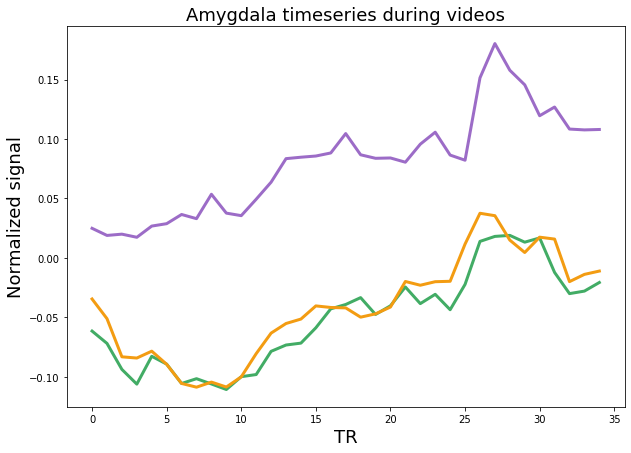

In [63]:
plt.figure(figsize=(10,7))

my_colors = ['#42AC65','#9C6CC7', '#F39C12']

# Plot the time series
plt.plot(h_video_amy_mean, label='heights amygdala',color = my_colors[0], linewidth=3)
plt.plot(so_video_amy_mean, label='social amygdala',color = my_colors[1], linewidth=3)
plt.plot(sp_video_amy_mean, label='spiders amygdala',color = my_colors[2], linewidth=3)


# Label axes
plt.xlabel('TR', fontsize =18)
plt.ylabel('Normalized signal', fontsize =18)
plt.title('Amygdala timeseries during videos',fontsize =18)
# Show the plot
plt.show()

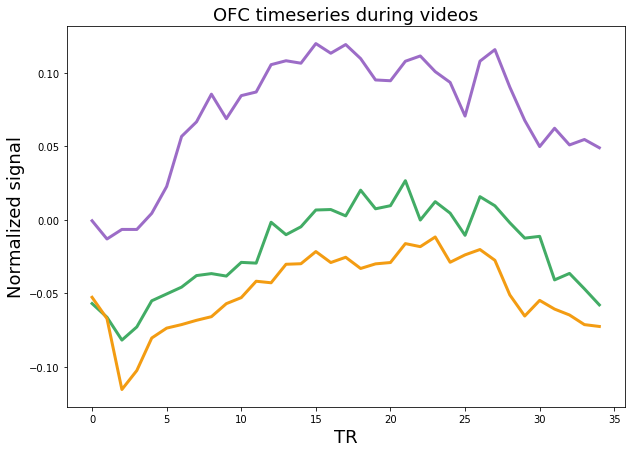

In [62]:
plt.figure(figsize=(10,7))

my_colors = ['#42AC65','#9C6CC7', '#F39C12']

# Plot the time series
plt.plot(h_video_ofc_mean, label='heights ofc',color = my_colors[0], linewidth=3)
plt.plot(so_video_ofc_mean, label='social ofc',color = my_colors[1], linewidth=3)
plt.plot(sp_video_ofc_mean, label='spiders ofc',color = my_colors[2], linewidth=3)


# Label axes
plt.xlabel('TR', fontsize =18)
plt.ylabel('Normalized signal', fontsize =18)
plt.title('OFC timeseries during videos', fontsize =18)
# Show the plot

plt.show()

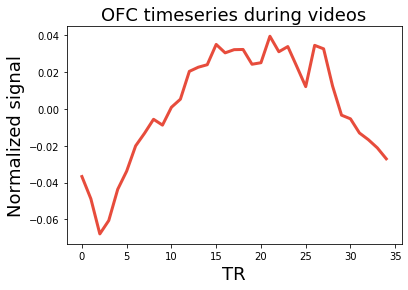

In [70]:

video_ofc_mean = np.mean([sp_video_ofc_mean, so_video_ofc_mean, h_video_ofc_mean], axis = 0) 
plt.plot(video_ofc_mean, label='OFC timeseries during videos',color = '#E74C3C', linewidth=3)


# Label axes
plt.xlabel('TR', fontsize=18)
plt.ylabel('Normalized signal', fontsize=18)
plt.title('OFC timeseries during videos', fontsize=18)
# Show the plot
plt.show()

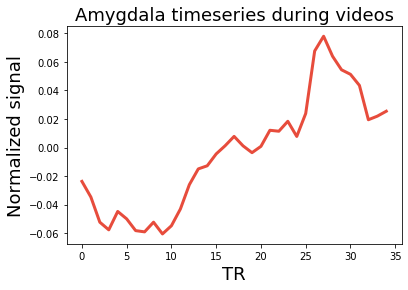

In [69]:


video_amy_mean = np.mean([sp_video_amy_mean, so_video_amy_mean, h_video_amy_mean], axis = 0) 
plt.plot(video_amy_mean, label='Amygdala timeseries during videos', color='#E74C3C', linewidth=3)

# Label axes
plt.xlabel('TR', fontsize=18)
plt.ylabel('Normalized signal', fontsize=18)
plt.title('Amygdala timeseries during videos',fontsize=18)
# Show the plot
plt.show()

In [ ]:
# univaraite:

calculate = True

if calculate:  
    h_vid_l_amy_ts, h_vid_r_amy_ts, h_vid_l_ofc_ts, h_vid_r_ofc_ts = [], [], [],[]
    so_vid_l_amy_ts, so_vid_r_amy_ts, so_vid_l_ofc_ts, so_vid_r_ofc_ts = [], [], [],[]
    sp_vid_l_amy_ts, sp_vid_r_amy_ts, sp_vid_l_ofc_ts, sp_vid_r_ofc_ts = [], [], [],[]


    duration = 35 # plot the 10 seconds after the videos

    for s in subjects_list:
        print(f'running subject {s}')


        task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
        task_csv = task_file[0]

        for run in [1,2,3]:
            events = create_events_dataframe(task_csv, run, 'VideoCategory').reset_index(drop=True)
            ##get confounds info:
            confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
            cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=False)

            func_str = f'{s}/run{run}.nii.gz'
            func_path = data_dir + func_str
            fmri_img = nib.load(func_path)
    

           
            fmri_glm = FirstLevelModel(t_r=1,
                                       noise_model='ar3',
                                       standardize=True,
                                       hrf_model='spm',
                                       drift_model='cosine',
                                       high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=6, minimize_memory=False)
            fmri_glm.fit(fmri_img, events, confounds=cov)
            
            
      
        


In [37]:
calculate = True
ts_type = 'predicted'
if calculate:  
    h_vid_l_amy_ts, h_vid_r_amy_ts, h_vid_l_ofc_ts, h_vid_r_ofc_ts = [], [], [],[]
    so_vid_l_amy_ts, so_vid_r_amy_ts, so_vid_l_ofc_ts, so_vid_r_ofc_ts = [], [], [],[]
    sp_vid_l_amy_ts, sp_vid_r_amy_ts, sp_vid_l_ofc_ts, sp_vid_r_ofc_ts = [], [], [],[]


    duration = 35 # plot the 10 seconds after the videos

    for s in subjects_list:
        print(f'running subject {s}')


        task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
        task_csv = task_file[0]

        for run in [1,2,3]:
            events = create_events_dataframe(task_csv, run, 'VideoCategory').reset_index(drop=True)
            ##get confounds info:
            confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
            cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=False)

            func_str = f'{s}/run{run}.nii.gz'
            func_path = data_dir + func_str
            fmri_img = nib.load(func_path)
            if ts_type =='raw':
                cleaned_img = image.clean_img(fmri_img, confounds=cov.values, high_pass=0.01, t_r=1, 
                                              detrend=False, standardize=True, mask_img=mask)

            elif ts_type == 'predicted':
                fmri_glm = FirstLevelModel(t_r=1,
                                           noise_model='ar3',
                                           standardize=True,
                                           hrf_model='spm',
                                           drift_model='cosine',
                                           high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=6, minimize_memory=False)
                fmri_glm.fit(fmri_img, events, confounds=cov)
                cleaned_img = fmri_glm.predicted[0]
            
            subc_ts = subc_masker.fit_transform(cleaned_img)
            cort_ts = cort_masker.fit_transform(cleaned_img)

            # Slice the time series data according to start_time and duration
            for i in range(len(events)):
                onset = int(events.loc[i,'onset'])

                video = int(events.loc[i, 'trial_type'])

                if video == 1:
                    h_vid_l_amy_ts.append(subc_ts[onset : onset + duration, l_amy_label_index])
                    h_vid_r_amy_ts.append(subc_ts[onset : onset + duration, r_amy_label_index])
                    h_vid_l_ofc_ts.append(cort_ts[onset : onset + duration, l_ofc_label_index])
                    h_vid_r_ofc_ts.append(cort_ts[onset : onset + duration, r_ofc_label_index])
                elif video == 2:
                    so_vid_l_amy_ts.append(subc_ts[onset : onset + duration, l_amy_label_index])
                    so_vid_r_amy_ts.append(subc_ts[onset : onset + duration, r_amy_label_index])
                    so_vid_l_ofc_ts.append(cort_ts[onset : onset + duration, l_ofc_label_index])
                    so_vid_r_ofc_ts.append(cort_ts[onset : onset + duration, r_ofc_label_index])
                elif video == 3:
                    sp_vid_l_amy_ts.append(subc_ts[onset : onset + duration, l_amy_label_index])
                    sp_vid_r_amy_ts.append(subc_ts[onset : onset + duration, r_amy_label_index])
                    sp_vid_l_ofc_ts.append(cort_ts[onset : onset + duration, l_ofc_label_index])
                    sp_vid_r_ofc_ts.append(cort_ts[onset : onset + duration, r_ofc_label_index])

    # average for the four areas:
    h_video_l_amy_mean = np.mean(h_vid_l_amy_ts, axis =0)
    so_video_l_amy_mean = np.mean(so_vid_l_amy_ts, axis =0)
    sp_video_l_amy_mean = np.mean(sp_vid_l_amy_ts, axis =0)
    
    h_video_l_ofc_mean = np.mean(h_vid_l_ofc_ts, axis =0)
    so_video_l_ofc_mean = np.mean(so_vid_l_ofc_ts, axis =0)
    sp_video_l_ofc_mean = np.mean(sp_vid_l_ofc_ts, axis =0)
    
    h_video_r_amy_mean = np.mean(h_vid_r_amy_ts, axis =0)
    so_video_r_amy_mean = np.mean(so_vid_r_amy_ts, axis =0)
    sp_video_r_amy_mean = np.mean(sp_vid_r_amy_ts, axis =0)
    
    h_video_r_ofc_mean = np.mean(h_vid_r_ofc_ts, axis =0)
    so_video_r_ofc_mean = np.mean(so_vid_r_ofc_ts, axis =0)
    sp_video_r_ofc_mean = np.mean(sp_vid_r_ofc_ts, axis =0)

    # save:
    
    np.save(base_dir + f'fmri_results/{ts_type}_heights_video_l_amy_mean.npy', h_video_l_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_social_video_l_amy_mean.npy', so_video_l_amy_mean)
    np.save(base_dir + f'fmri_results/{ts_type}_spiders_video_l_amy_mean.npy', sp_video_l_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_heights_video_l_ofc_mean.npy', h_video_l_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_social_video_l_ofc_mean.npy', so_video_l_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_spiders_video_l_ofc_mean.npy', sp_video_l_ofc_mean) 
    
    np.save(base_dir + f'fmri_results/{ts_type}_heights_video_r_amy_mean.npy', h_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_social_video_r_amy_mean.npy', so_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_spiders_video_r_amy_mean.npy', sp_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_heights_video_r_ofc_mean.npy', h_video_r_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_social_video_r_ofc_mean.npy', so_video_r_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_spiders_video_r_ofc_mean.npy', sp_video_r_ofc_mean) 


else:
    h_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_heights_video_l_amy_mean.npy')
    so_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_social_video_l_amy_mean.npy')
    sp_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_spiders_video_l_amy_mean.npy')
    
    h_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_heights_video_l_ofc_mean.npy')
    so_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_social_video_l_ofc_mean.npy')
    sp_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_spiders_video_l_ofc_mean.npy')
    
    h_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_heights_video_r_amy_mean.npy')
    so_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_social_video_r_amy_mean.npy')
    sp_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_spiders_video_r_amy_mean.npy')
    
    h_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_heights_video_r_ofc_mean.npy')
    so_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_social_video_r_ofc_mean.npy')
    sp_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_spiders_video_r_ofc_mean.npy')
    

    

running subject 04
running subject 05
running subject 06
running subject 07
running subject 08
running subject 09
running subject 10
running subject 11
running subject 12
running subject 13
running subject 14
running subject 15
running subject 16
running subject 17
running subject 18
running subject 19
running subject 23
running subject 25
running subject 26
running subject 28
running subject 29


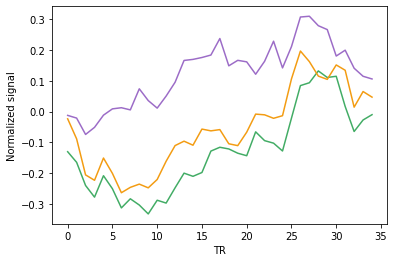

In [38]:
plt.figure()

my_colors = ['#42AC65','#9C6CC7', '#F39C12']

# Plot the time series
plt.plot(h_video_l_amy_mean, label='heights left amygdala',color = my_colors[0])
plt.plot(so_video_l_amy_mean, label='social left amygdala',color = my_colors[1])
plt.plot(sp_video_l_amy_mean, label='spiders left amygdala',color = my_colors[2])


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

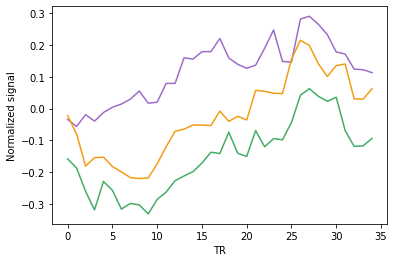

In [39]:
plt.figure()

my_colors = ['#42AC65','#9C6CC7', '#F39C12']

# Plot the time series
plt.plot(h_video_r_amy_mean, label='heights right amygdala',color = my_colors[0])
plt.plot(so_video_r_amy_mean, label='social right amygdala',color = my_colors[1])
plt.plot(sp_video_r_amy_mean, label='spiders right amygdala',color = my_colors[2])


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

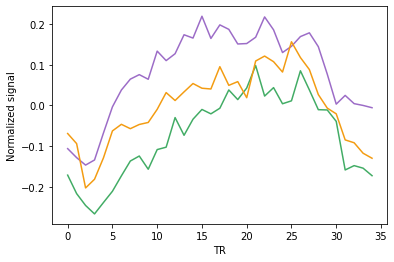

In [40]:
plt.figure()

my_colors = ['#42AC65','#9C6CC7', '#F39C12']

# Plot the time series
plt.plot(h_video_l_ofc_mean, label='heights left ofc',color = my_colors[0])
plt.plot(so_video_l_ofc_mean, label='social left ofc',color = my_colors[1])
plt.plot(sp_video_l_ofc_mean, label='spiders left ofc',color = my_colors[2])


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

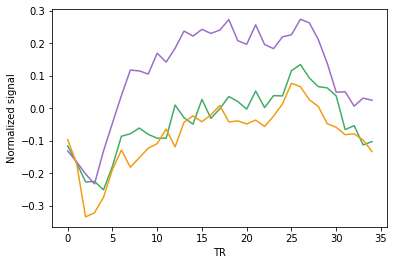

In [41]:
plt.figure()

my_colors = ['#42AC65','#9C6CC7', '#F39C12']

# Plot the time series
plt.plot(h_video_r_ofc_mean, label='heights right ofc',color = my_colors[0])
plt.plot(so_video_r_ofc_mean, label='social right ofc',color = my_colors[1])
plt.plot(sp_video_r_ofc_mean, label='spiders right ofc',color = my_colors[2])


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

In [ ]:
calculate = True
ts_type = 'raw'
if calculate:    
    low_vid_l_amy_ts, low_vid_r_amy_ts, low_vid_l_ofc_ts, low_vid_r_ofc_ts = [], [], [],[]
    high_vid_l_amy_ts, high_vid_r_amy_ts, high_vid_l_ofc_ts, high_vid_r_ofc_ts = [], [], [],[]


    duration = 35 # plot the 10 seconds after the videos

    for s in subjects_list[0:1]:
        print(f'running subject {s}')


        task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
        task_csv = task_file[0]

        for run in [1,2,3]:
            events = create_events_dataframe(task_csv, run, 'OneRegPerVid').reset_index(drop=True)
            ##get confounds info:
            confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
            cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=False)

            func_str = f'{s}/run{run}.nii.gz'
            func_path = data_dir + func_str
            fmri_img = nib.load(func_path)
            if ts_type =='raw':
                cleaned_img = image.clean_img(fmri_img, confounds=cov.values, high_pass=0.01, t_r=1, 
                                              detrend=False, standardize=True, mask_img=mask)

            elif ts_type == 'predicted':
                fmri_glm = FirstLevelModel(t_r=1,
                                           noise_model='ar3',
                                           standardize=True,
                                           hrf_model='spm',
                                           drift_model='cosine',
                                           high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=6, minimize_memory=False)
                fmri_glm.fit(fmri_img, events, confounds=cov)
                cleaned_img = fmri_glm.predicted[0]
            
            subc_ts = subc_masker.fit_transform(cleaned_img)
            cort_ts = cort_masker.fit_transform(cleaned_img)

            # Slice the time series data according to start_time and duration
            for i in range(len(events)):
                onset = int(events.loc[i,'onset'])

                video = int(events.loc[i, 'trial_type'])

                if check_high_low(video) == 'low':
                    low_vid_l_amy_ts.append(subc_ts[onset : onset + duration, l_amy_label_index])
                    low_vid_r_amy_ts.append(subc_ts[onset : onset + duration, r_amy_label_index])
                    low_vid_l_ofc_ts.append(cort_ts[onset : onset + duration, l_ofc_label_index])
                    low_vid_r_ofc_ts.append(cort_ts[onset : onset + duration, r_ofc_label_index])
                elif check_high_low(video) == 'high':
                    high_vid_l_amy_ts.append(subc_ts[onset : onset + duration, l_amy_label_index])
                    high_vid_r_amy_ts.append(subc_ts[onset : onset + duration, r_amy_label_index])
                    high_vid_l_ofc_ts.append(cort_ts[onset : onset + duration, l_ofc_label_index])
                    high_vid_r_ofc_ts.append(cort_ts[onset : onset + duration, r_ofc_label_index])


    low_video_l_amy_mean = np.mean(low_vid_l_amy_ts, axis =0)
    high_video_l_amy_mean = np.mean(high_vid_l_amy_ts, axis =0)
    low_video_l_ofc_mean = np.mean(low_vid_l_ofc_ts, axis =0)
    high_video_l_ofc_mean = np.mean(high_vid_l_ofc_ts, axis =0)
    
    low_video_r_amy_mean = np.mean(low_vid_r_amy_ts, axis =0)
    high_video_r_amy_mean = np.mean(high_vid_r_amy_ts, axis =0)
    low_video_r_ofc_mean = np.mean(low_vid_r_ofc_ts, axis =0)
    high_video_r_ofc_mean = np.mean(high_vid_r_ofc_ts, axis =0)

    # save:
    
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_l_amy_mean.npy', low_video_l_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_l_amy_mean.npy', high_video_l_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_l_ofc_mean.npy', low_video_l_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_l_ofc_mean.npy', high_video_l_ofc_mean) 
    
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_r_amy_mean.npy', low_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_r_amy_mean.npy', high_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_r_ofc_mean.npy', low_video_r_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_r_ofc_mean.npy', high_video_r_ofc_mean) 


else:
    low_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_l_amy_mean.npy')
    high_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_l_amy_mean.npy')
    low_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_l_ofc_mean.npy')
    high_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_l_ofc_mean.npy')
    
    low_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_r_amy_mean.npy')
    high_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_r_amy_mean.npy')
    low_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_r_ofc_mean.npy')
    high_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_r_ofc_mean.npy')
    

    

In [ ]:
plt.figure()

# Plot the time series
plt.plot(low_video_l_amy_mean, label='low fear left amygdala',color = "#7FB1ED")
plt.plot(high_video_l_amy_mean, label='high fear left amygdala',color = "#0076BA")


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

In [ ]:
plt.figure()

# Plot the time series
plt.plot(low_video_r_amy_mean, label='low fear right amygdala',color = "#7FB1ED")
plt.plot(high_video_r_amy_mean, label='high fear right amygdala',color = "#0076BA")


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

In [ ]:
plt.figure()

# Plot the time series
plt.plot(low_video_l_ofc_mean, label='low fear left ofc',color = "#7FB1ED")
plt.plot(high_video_l_ofc_mean, label='high fear left ofc',color = "#0076BA")



# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

In [ ]:
plt.figure()

# Plot the time series
plt.plot(low_video_r_ofc_mean, label='low fear right ofc', color = "#7FB1ED")
plt.plot(high_video_r_ofc_mean, label='high fear right ofc', color = "#0076BA")


# Label axes
plt.xlabel('TR')
plt.ylabel('Normalized signal')

# Show the plot
plt.show()

In [16]:
calculate = True
ts_type = 'raw'
if calculate:    
    
    vid_l_amy_ts, vid_r_amy_ts, vid_l_ofc_ts, vid_r_ofc_ts = [], [], [],[]


    duration = 35 # plot the 10 seconds after the videos

    for s in subjects_list[0:1]:
        print(f'running subject {s}')


        task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
        task_csv = task_file[0]

        for run in [1,2,3]:
            events = create_events_dataframe(task_csv, run, 'OneRegPerVid').reset_index(drop=True)
            ##get confounds info:
            confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
            cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=False)

            func_str = f'{s}/run{run}.nii.gz'
            func_path = data_dir + func_str
            fmri_img = nib.load(func_path)
            if ts_type =='raw':
                cleaned_img = image.clean_img(fmri_img, confounds=cov.values, high_pass=0.01, t_r=1, 
                                              detrend=False, standardize=True, mask_img=mask)

            elif ts_type == 'predicted':
                fmri_glm = FirstLevelModel(t_r=1,
                                           noise_model='ar3',
                                           standardize=True,
                                           hrf_model='spm',
                                           drift_model='cosine',
                                           high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=6, minimize_memory=False)
                fmri_glm.fit(fmri_img, events, confounds=cov)
                cleaned_img = fmri_glm.predicted[0]
            
            subc_ts = subc_masker.fit_transform(cleaned_img)
            cort_ts = cort_masker.fit_transform(cleaned_img)

            # Slice the time series data according to start_time and duration
            for i in range(len(events)):
                onset = int(events.loc[i,'onset'])

                video = int(events.loc[i, 'trial_type'])

           
              
                vid_l_amy_ts.append(subc_ts[onset : onset + duration, l_amy_label_index])
                vid_r_amy_ts.append(subc_ts[onset : onset + duration, r_amy_label_index])
                vid_l_ofc_ts.append(cort_ts[onset : onset + duration, l_ofc_label_index])
                vid_r_ofc_ts.append(cort_ts[onset : onset + duration, r_ofc_label_index])


    low_video_l_amy_mean = np.mean(low_vid_l_amy_ts, axis =0)
    high_video_l_amy_mean = np.mean(high_vid_l_amy_ts, axis =0)
    low_video_l_ofc_mean = np.mean(low_vid_l_ofc_ts, axis =0)
    high_video_l_ofc_mean = np.mean(high_vid_l_ofc_ts, axis =0)
    
    low_video_r_amy_mean = np.mean(low_vid_r_amy_ts, axis =0)
    high_video_r_amy_mean = np.mean(high_vid_r_amy_ts, axis =0)
    low_video_r_ofc_mean = np.mean(low_vid_r_ofc_ts, axis =0)
    high_video_r_ofc_mean = np.mean(high_vid_r_ofc_ts, axis =0)

    # save:
    
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_l_amy_mean.npy', low_video_l_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_l_amy_mean.npy', high_video_l_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_l_ofc_mean.npy', low_video_l_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_l_ofc_mean.npy', high_video_l_ofc_mean) 
    
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_r_amy_mean.npy', low_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_r_amy_mean.npy', high_video_r_amy_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_low_video_r_ofc_mean.npy', low_video_r_ofc_mean) 
    np.save(base_dir + f'fmri_results/{ts_type}_high_video_r_ofc_mean.npy', high_video_r_ofc_mean) 


else:
    low_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_l_amy_mean.npy')
    high_video_l_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_l_amy_mean.npy')
    low_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_l_ofc_mean.npy')
    high_video_l_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_l_ofc_mean.npy')
    
    low_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_r_amy_mean.npy')
    high_video_r_amy_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_r_amy_mean.npy')
    low_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_low_video_r_ofc_mean.npy')
    high_video_r_ofc_mean = np.load(base_dir + f'fmri_results/{ts_type}_high_video_r_ofc_mean.npy')
    



['Background',
 'Left Frontal Pole',
 'Right Frontal Pole',
 'Left Insular Cortex',
 'Right Insular Cortex',
 'Left Superior Frontal Gyrus',
 'Right Superior Frontal Gyrus',
 'Left Middle Frontal Gyrus',
 'Right Middle Frontal Gyrus',
 'Left Inferior Frontal Gyrus, pars triangularis',
 'Right Inferior Frontal Gyrus, pars triangularis',
 'Left Inferior Frontal Gyrus, pars opercularis',
 'Right Inferior Frontal Gyrus, pars opercularis',
 'Left Precentral Gyrus',
 'Right Precentral Gyrus',
 'Left Temporal Pole',
 'Right Temporal Pole',
 'Left Superior Temporal Gyrus, anterior division',
 'Right Superior Temporal Gyrus, anterior division',
 'Left Superior Temporal Gyrus, posterior division',
 'Right Superior Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, anterior division',
 'Right Middle Temporal Gyrus, anterior division',
 'Left Middle Temporal Gyrus, posterior division',
 'Right Middle Temporal Gyrus, posterior division',
 'Left Middle Temporal Gyrus, temporooccipita

In [ ]:
# examine the coefficient from these ROIs:


sg_h = base_dir + "fmri_results/permutation_test/train_Situation_General_test_Heights_permutation_distribution_pearsonr.nii.gz"
sg_so = base_dir + "fmri_results/permutation_test/train_Situation_General_test_Social_permutation_distribution_pearsonr.nii.gz"
sg_sp = base_dir + "fmri_results/permutation_test/train_Situation_General_test_Spiders_permutation_distribution_pearsonr.nii.gz"

In [61]:
for i in range(len(events)):
    events.loc[i,'duration']

In [ ]:
dm_name = 'SNR_timecourse'
res_dir = base_dir + f'fmri_results/{dm_name}/'
if not os.path.isdir(res_dir):
        os.mkdir(res_dir)


for s in subjects_list:
    print(f'running subject {s}')

        
    task_file = glob.glob(logfiles_dir + f'AffVids_logfile_{s}_edited.txt') 
    task_csv = task_file[0]
    
    for run in [1,2,3]:
        events = create_events_dataframe(task_csv, run, 'OneRegPerVid')
        ##get confounds info:
        confounds_str = f'sub-{s}_task-AffVids_run-0{run}_bold_confounds.tsv'
        cov = CreateConfoundMatrix(confounds_dir + confounds_str, confounds_of_interest, s, run, add_vis=True)

        fmri_glm = FirstLevelModel(t_r=1,
                           noise_model='ar3',
                           standardize=True,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01, mask_img=gm_mask_img,smoothing_fwhm=6)
        
        func_str = f'{s}/run{run}.nii.gz'
        func_path = data_dir + func_str
        fmri_img = nib.load(func_path)
        fmri_glm = fmri_glm.fit(fmri_img, events, confounds=cov)
        
        # save design_matrix for every run
        design_matrix = fmri_glm.design_matrices_[0]

        plot_design_matrix(design_matrix, output_file=join(sub_output_dir, f'design_matrix_run{run}.png'))
        contrast_matrix = np.eye(design_matrix.shape[1])
        # extract the betas
        for i in range(12):
            print(f'saving beta for video {design_matrix.columns[i]}')
            eff = fmri_glm.fit_transform()
            nii_file_path = sub_output_dir + f'/sub-{s}_run-{run}_beta_video-{design_matrix.columns[i]}_gm_visreg.nii.gz'
            nib.save(eff, nii_file_path)

        
        